# Basic HEMS implementation using MILP

In [1]:
import cvxpy as cp
import numpy as np

## Constants

In [2]:
from HEMS.const import DT_DEFAULT

T = 24 * int(1 / DT_DEFAULT) - 1  # number of time steps per day
solver = cp.HIGHS
print(f"DT_DEFAULT = {DT_DEFAULT} h, T = {T} steps/day")

DT_DEFAULT = 0.25 h, T = 95 steps/day


## EV control prototyping

In [3]:
from HEMS.load import EV

In [4]:
ev = EV(T)

# Simple time-of-use electricity price signal [€/kWh]
# Cheap at night (0–7h, 21–24h), expensive during the day (7–21h)
price = np.where(
    np.arange(T) < 7 * 4,      # 00:00–07:00
    0.05,
    np.where(
        np.arange(T) >= 21 * 4,    # 21:00–24:00
        0.05,
        0.25,                        # 07:00–21:00
    ),
)

# Schedule two trips: 8:00–18:00 consuming 30 kWh, and 19:00–21:00 consuming 25 kWh
ev.schedule_trips([(8 * 4, 18 * 4, 30.0), (19 * 4, 20 * 4, 25.0)])

# Cost-minimising objective: pay as little as possible for charging
objective = cp.Minimize(ev.dt * (price @ ev.P))

prob = cp.Problem(objective, ev.constraints())

assert prob.is_dcp(), "Problem is not DCP compliant"
assert prob.is_dpp(), "Problem is not DPP compliant"

prob.solve(solver=solver, verbose=False)
print(f"Status : {prob.status}")
print(f"Cost   : {prob.value:.4f} €")


Status : optimal
Cost   : 4.7611 €


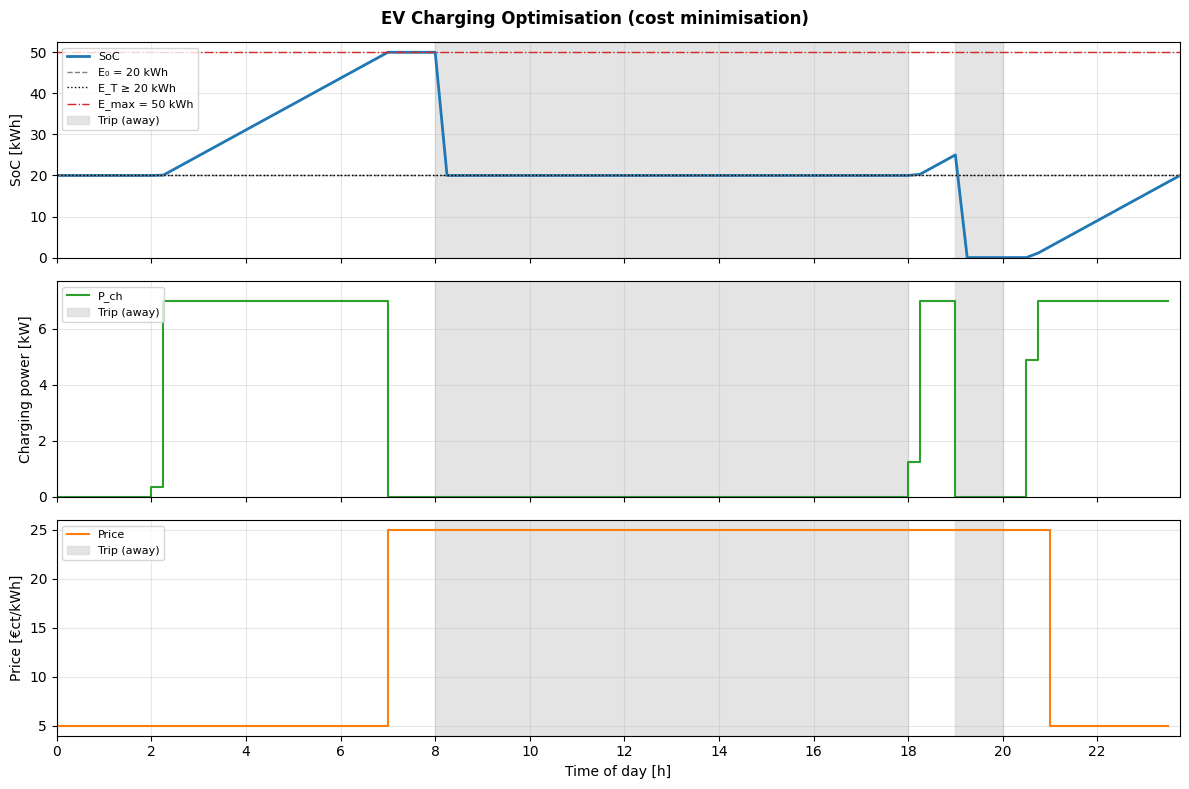

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

t_power = np.arange(T) * ev.dt          # time axis for power/price [h]
t_soc   = np.arange(T + 1) * ev.dt      # time axis for SoC [h]

# Extract solved values
soc   = ev.E.value                       # kWh,  shape (T+1,)
p_ch  = ev.P_ch.value                    # kW,   shape (T,)
avail = ev.a.value                       # 0/1,  shape (T,)


def shade_trips(ax, t_power, avail, dt, **kwargs):
    """Shade each contiguous unavailability window on ax."""
    unavail = (avail == 0).astype(int)
    edges = np.diff(np.concatenate(([0], unavail, [0])))
    starts = t_power[np.where(edges == 1)[0]]
    ends   = t_power[np.where(edges == -1)[0] - 1] + dt
    first = True
    for s, e in zip(starts, ends):
        ax.axvspan(s, e, label="Trip (away)" if first else None, **kwargs)
        first = False


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle("EV Charging Optimisation (cost minimisation)", fontweight="bold")

trip_kwargs = dict(color="lightgrey", alpha=0.6)

# --- Panel 1: State of Charge ---
ax = axes[0]
ax.plot(t_soc, soc, color="tab:blue", lw=2, label="SoC")
ax.axhline(ev.E_0.value, color="grey",    ls="--", lw=1, label=f"E₀ = {ev.E_0.value:.0f} kWh")
ax.axhline(ev.E_T.value, color="black",   ls=":",  lw=1, label=f"E_T ≥ {ev.E_T.value:.0f} kWh")
ax.axhline(ev.E_max,     color="tab:red", ls="-.", lw=1, label=f"E_max = {ev.E_max:.0f} kWh")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
ax.set_ylabel("SoC [kWh]")
ax.set_ylim(0, ev.E_max * 1.05)
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Charging power ---
ax = axes[1]
ax.step(t_power, p_ch, where="post", color="tab:green", lw=1.5, label="P_ch")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
ax.set_ylabel("Charging power [kW]")
ax.set_ylim(0, ev.P_ch_max * 1.1)
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: Electricity price ---
ax = axes[2]
ax.step(t_power, price * 100, where="post", color="tab:orange", lw=1.5, label="Price")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
grey_patch = mpatches.Patch(**trip_kwargs, label="Trip (away)")
ax.legend(handles=[ax.get_lines()[0], grey_patch], loc="upper left", fontsize=8)
ax.set_ylabel("Price [€ct/kWh]")
ax.set_xlabel("Time of day [h]")
ax.set_xlim(0, T * ev.dt)
ax.set_xticks(range(0, int(T * ev.dt) + 1, 2))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Solar generation prototyping

In [6]:
from HEMS.solar import Solar
from HEMS.weather import fetch_open_meteo, resample_weather
import pandas as pd

# --- Fetch historical weather data for Amsterdam, June 2025 ---
weather = fetch_open_meteo(
    latitude=52.37,
    longitude=4.90,
    start_date="2025-06-01",
    end_date="2025-06-30",
    timezone="Europe/Amsterdam",
)
print(f"Fetched {len(weather)} hourly records")

# --- Resample to DT_DEFAULT (15-min) ---
weather = resample_weather(weather, dt=DT_DEFAULT)
print(f"Resampled to {len(weather)} records at {DT_DEFAULT*60:.0f}-min resolution")
print(weather.head())

Fetched 720 hourly records
Resampled to 2877 records at 15-min resolution
                           ghi  dni  dhi  temp_air  wind_speed
time                                                          
2025-06-01 00:00:00+02:00  0.0  0.0  0.0     17.30    2.472222
2025-06-01 00:15:00+02:00  0.0  0.0  0.0     17.15    2.263889
2025-06-01 00:30:00+02:00  0.0  0.0  0.0     17.00    2.055556
2025-06-01 00:45:00+02:00  0.0  0.0  0.0     16.85    1.847222
2025-06-01 01:00:00+02:00  0.0  0.0  0.0     16.70    1.638889


In [7]:
# --- Create a 5 kWp south-facing PV system in Amsterdam ---
T_sol = len(weather)

solar = Solar(
    T=T_sol,
    dt=DT_DEFAULT,
    pdc0=5.0,           # 5 kWp array
    pac0=5.0,           # 5 kW inverter
    surface_tilt=35.0,  # 35° tilt
    surface_azimuth=180.0,  # south-facing
    latitude=52.37,
    longitude=4.90,
    timezone="Europe/Amsterdam",
    curtailable=False,
)

# Compute AC generation from the fetched weather data
pac_kw = solar.compute_generation(
    times=weather.index,
    ghi=weather["ghi"].to_numpy(),
    temp_air=weather["temp_air"].to_numpy(),
    wind_speed=weather["wind_speed"].to_numpy(),
    dni=weather["dni"].to_numpy(),
    dhi=weather["dhi"].to_numpy(),
)

monthly_yield = np.sum(pac_kw) * DT_DEFAULT
peak_power = pac_kw.max()
print(f"Time steps    : {T_sol} ({DT_DEFAULT*60:.0f}-min resolution)")
print(f"Peak AC power : {peak_power:.2f} kW")
print(f"Monthly yield : {monthly_yield:.1f} kWh")
print(f"Capacity factor: {monthly_yield / (solar.pdc0 * T_sol * DT_DEFAULT) * 100:.1f}%")

Time steps    : 2877 (15-min resolution)
Peak AC power : 4.31 kW
Monthly yield : 873.5 kWh
Capacity factor: 24.3%


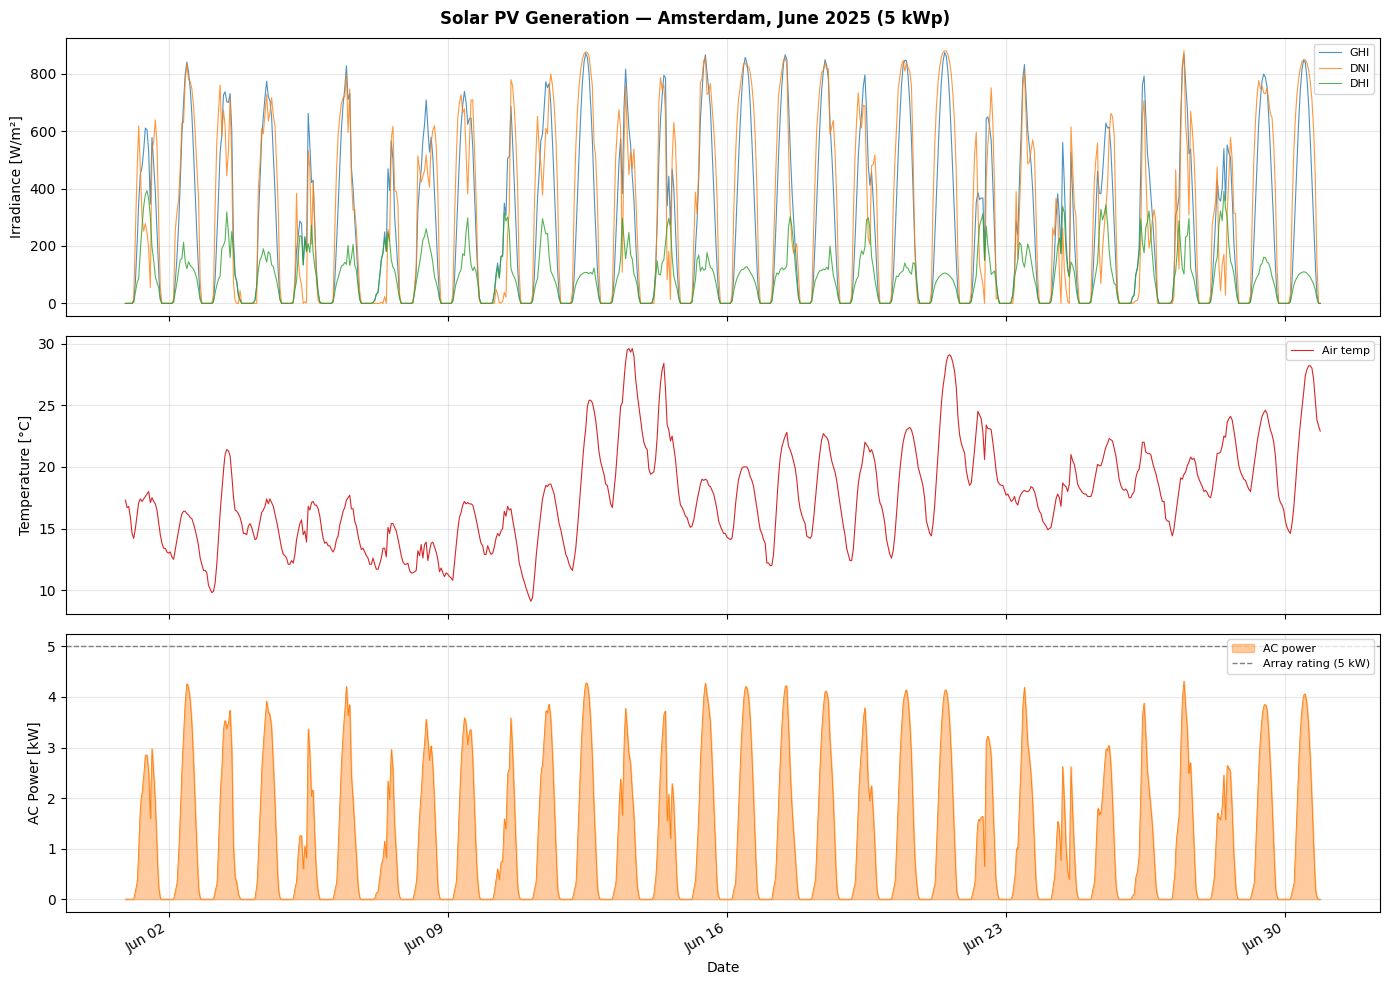

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle("Solar PV Generation — Amsterdam, June 2025 (5 kWp)", fontweight="bold")

times = weather.index

# --- Panel 1: Irradiance ---
ax = axes[0]
ax.plot(times, weather["ghi"], lw=0.8, alpha=0.8, label="GHI")
ax.plot(times, weather["dni"], lw=0.8, alpha=0.8, label="DNI")
ax.plot(times, weather["dhi"], lw=0.8, alpha=0.8, label="DHI")
ax.set_ylabel("Irradiance [W/m²]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Temperature ---
ax = axes[1]
ax.plot(times, weather["temp_air"], lw=0.8, color="tab:red", label="Air temp")
ax.set_ylabel("Temperature [°C]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: AC power output ---
ax = axes[2]
ax.fill_between(times, pac_kw, alpha=0.4, color="tab:orange", label="AC power")
ax.plot(times, pac_kw, lw=0.6, color="tab:orange")
ax.axhline(solar.pdc0, color="grey", ls="--", lw=1, label=f"Array rating ({solar.pdc0:.0f} kW)")
ax.set_ylabel("AC Power [kW]")
ax.set_xlabel("Date")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

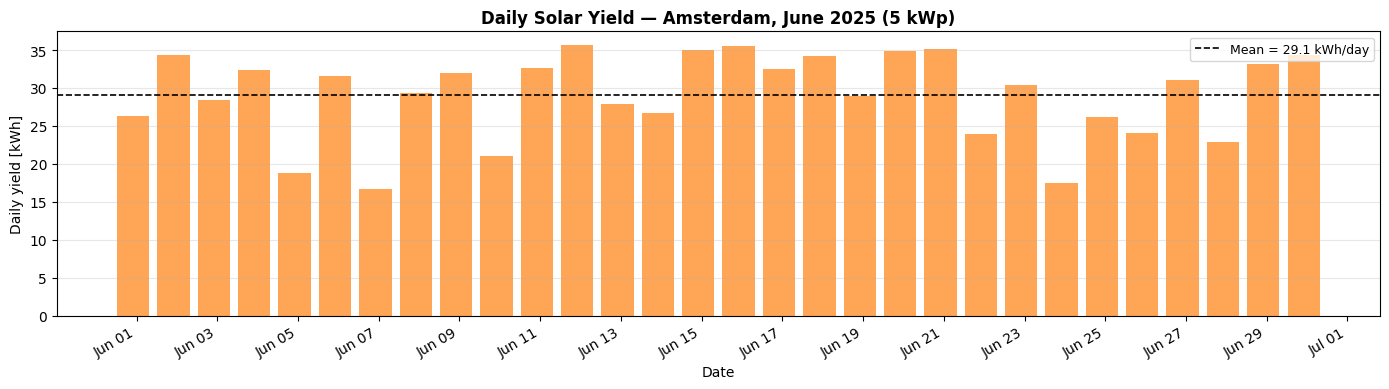

In [9]:
# --- Daily yield bar chart ---
daily_yield = pd.Series(pac_kw * DT_DEFAULT, index=weather.index).resample("D").sum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(daily_yield.index, daily_yield.values, width=0.8, color="tab:orange", alpha=0.7)
ax.axhline(daily_yield.mean(), color="black", ls="--", lw=1.2,
           label=f"Mean = {daily_yield.mean():.1f} kWh/day")
ax.set_ylabel("Daily yield [kWh]")
ax.set_xlabel("Date")
ax.set_title("Daily Solar Yield — Amsterdam, June 2025 (5 kWp)", fontweight="bold")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

### Curtailment demo (single day)

We create a **curtailable** solar model for the sunniest day in June and impose a
feed-in limit. The optimiser decides how much generation to keep versus curtail.

In [10]:
# --- Pick the sunniest day from the month ---
best_day = daily_yield.idxmax().strftime("%Y-%m-%d")
day_mask = weather.index.normalize() == pd.Timestamp(best_day, tz="Europe/Amsterdam")
weather_day = weather.loc[day_mask]
T_day = len(weather_day)

print(f"Sunniest day: {best_day}  ({daily_yield.max():.1f} kWh)")
print(f"Time steps:   {T_day}  (dt={DT_DEFAULT} h)")

# --- Curtailable solar model for that day ---
solar_curt = Solar(
    T=T_day,
    dt=DT_DEFAULT,
    pdc0=5.0,
    pac0=5.0,
    surface_tilt=35.0,
    surface_azimuth=180.0,
    latitude=52.37,
    longitude=4.90,
    timezone="Europe/Amsterdam",
    curtailable=True,  # <-- optimiser can curtail
)

# Compute the maximum available generation
pac_day = solar_curt.compute_generation(
    times=weather_day.index,
    ghi=weather_day["ghi"].values,
    temp_air=weather_day["temp_air"].values,
    wind_speed=weather_day["wind_speed"].values,
    dni=weather_day["dni"].values,
    dhi=weather_day["dhi"].values,
)

# --- Feed-in limit: curtail anything above 3 kW ---
feed_in_limit = 3.0  # kW

constraints = solar_curt.constraints()
constraints += [solar_curt.P <= feed_in_limit]

# Maximise total generation subject to the feed-in cap
objective = cp.Maximize(cp.sum(solar_curt.P))
prob = cp.Problem(objective, constraints)
prob.solve(solver=solver)

p_curt = solar_curt.P.value
energy_available = np.sum(pac_day) * DT_DEFAULT
energy_delivered = np.sum(p_curt) * DT_DEFAULT
energy_curtailed = energy_available - energy_delivered

print(f"\nStatus        : {prob.status}")
print(f"Available     : {energy_available:.2f} kWh")
print(f"Delivered     : {energy_delivered:.2f} kWh")
print(f"Curtailed     : {energy_curtailed:.2f} kWh ({energy_curtailed/energy_available*100:.1f}%)")

Sunniest day: 2025-06-12  (35.7 kWh)
Time steps:   96  (dt=0.25 h)

Status        : optimal
Available     : 35.68 kWh
Delivered     : 30.21 kWh
Curtailed     : 5.47 kWh (15.3%)


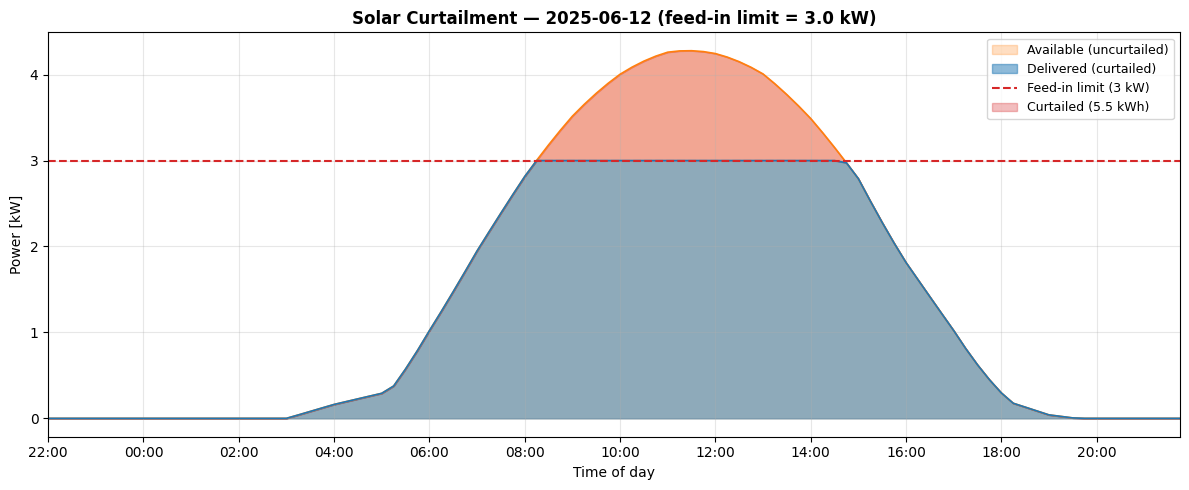

In [11]:
# --- Curtailment visualisation ---
hours = np.arange(T_day) * DT_DEFAULT
t_day = weather_day.index

fig, ax = plt.subplots(figsize=(12, 5))

# Available generation (uncurtailed)
ax.fill_between(t_day, pac_day, alpha=0.25, color="tab:orange", label="Available (uncurtailed)")
ax.plot(t_day, pac_day, lw=1.2, color="tab:orange")

# Delivered (after curtailment)
ax.fill_between(t_day, p_curt, alpha=0.5, color="tab:blue", label="Delivered (curtailed)")
ax.plot(t_day, p_curt, lw=1.2, color="tab:blue")

# Feed-in limit
ax.axhline(feed_in_limit, color="tab:red", ls="--", lw=1.5,
           label=f"Feed-in limit ({feed_in_limit:.0f} kW)")

# Shade curtailed energy
ax.fill_between(t_day, p_curt, pac_day, alpha=0.3, color="tab:red",
                label=f"Curtailed ({energy_curtailed:.1f} kWh)")

ax.set_ylabel("Power [kW]")
ax.set_xlabel("Time of day")
ax.set_title(f"Solar Curtailment — {best_day} (feed-in limit = {feed_in_limit} kW)", fontweight="bold")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(t_day[0], t_day[-1])
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()